In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

# Combine text data for tokenization and word2vec training
texts = pd.concat([train_df['clean_text'], test_df['clean_text']]).tolist()

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train_df['clean_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['clean_text'])

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
max_seq_length = max(max([len(seq) for seq in sequences_train]), max([len(seq) for seq in sequences_test]))
X_train_pad = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test_pad = pad_sequences(sequences_test, maxlen=max_seq_length)

# Train Word2Vec model
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Prepare labels
y_train = train_df['IsHatespeech'].values
y_test = test_df['IsHatespeech'].values

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

# Predict and evaluate performance
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

print("Deep Learning Model Performance with Word2Vec:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Epoch 1/10
59/59 - 59s - loss: 0.6215 - accuracy: 0.6477 - val_loss: 0.6169 - val_accuracy: 0.6719 - lr: 0.0010 - 59s/epoch - 1s/step
Epoch 2/10
59/59 - 31s - loss: 0.5927 - accuracy: 0.6802 - val_loss: 0.5953 - val_accuracy: 0.6772 - lr: 0.0010 - 31s/epoch - 529ms/step
Epoch 3/10
59/59 - 31s - loss: 0.5878 - accuracy: 0.6864 - val_loss: 0.6050 - val_accuracy: 0.6756 - lr: 0.0010 - 31s/epoch - 532ms/step
Epoch 4/10
59/59 - 33s - loss: 0.5777 - accuracy: 0.6952 - val_loss: 0.5832 - val_accuracy: 0.6815 - lr: 0.0010 - 33s/epoch - 555ms/step
Epoch 5/10
59/59 - 34s - loss: 0.5715 - accuracy: 0.6971 - val_loss: 0.5857 - val_accuracy: 0.6955 - lr: 0.0010 - 34s/epoch - 570ms/step
Epoch 6/10
59/59 - 31s - loss: 0.5678 - accuracy: 0.6967 - val_loss: 0.5735 - val_accuracy: 0.6933 - lr: 0.0010 - 31s/epoch - 525ms/step
Epoch 7/10
59/59 - 31s - loss: 0.5673 - accuracy: 0.6942 - val_loss: 0.5692 - val_accuracy: 0.6944 - lr: 0.0010 - 31s/epoch - 521ms/step
Epoch 8/10
59/59 - 32s - loss: 0.5632 - accu

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Load dataset
train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

# Combine text data for tokenization and word2vec training
texts = pd.concat([train_df['clean_text'], test_df['clean_text']]).tolist()

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train_df['clean_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['clean_text'])

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
max_seq_length = max(max([len(seq) for seq in sequences_train]), max([len(seq) for seq in sequences_test]))
X_train_pad = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test_pad = pad_sequences(sequences_test, maxlen=max_seq_length)

# Train Word2Vec model
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Prepare labels
y_train = train_df['IsHatespeech'].values
y_test = test_df['IsHatespeech'].values

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100,
                    weights=[embedding_matrix], input_length=max_seq_length,
                    trainable=False)) # Increased output dimension
model.add(Bidirectional(LSTM(512, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01)))) # Increased number of units
model.add(Dense(128, activation='relu')) # Increased number of units
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model (consider using cross-validation)
history = model.fit(X_train_pad, y_train, epochs=1, batch_size=128, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

# Predict and evaluate performance
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

print("Deep Learning Model Performance with Word2Vec:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

59/59 - 89s - loss: 1.6708 - accuracy: 0.6318 - val_loss: 0.7259 - val_accuracy: 0.6278 - lr: 0.0010 - 89s/epoch - 2s/step
Test Accuracy: 0.6278195381164551
59/59 [==============================] - 7s 120ms/step
Deep Learning Model Performance with Word2Vec:
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.66      0.64       944
           1       0.63      0.59      0.61       918

    accuracy                           0.63      1862
   macro avg       0.63      0.63      0.63      1862
weighted avg       0.63      0.63      0.63      1862

Accuracy: 0.6278195488721805
AUC-ROC: 0.6940590266238322
Confusion Matrix:
 [[627 317]
 [376 542]]
F1 Score: 0.6100168823860439
Precision: 0.6309662398137369
Recall: 0.5904139433551199


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load dataset
train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

# Combine
texts = pd.concat([train_df['clean_text'], test_df['clean_text']]).tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train_df['clean_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['clean_text'])

vocab_size = len(tokenizer.word_index) + 1

max_seq_length = max(max([len(seq) for seq in sequences_train]), max([len(seq) for seq in sequences_test]))
X_train_pad = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test_pad = pad_sequences(sequences_test, maxlen=max_seq_length)


sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


# Prepare labels (convert to float32)
y_train = train_df['IsHatespeech'].values.astype('float32')
y_test = test_df['IsHatespeech'].values.astype('float32')


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Bidirectional(LSTM(1024, return_sequences=True)))
model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[tf.keras.metrics.F1Score()])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


history = model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping, reduce_lr])

loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")


y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

print("Deep Learning Model Performance with Word2Vec:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Epoch 1/5
59/59 - 147s - loss: 0.7025 - f1_score: 0.6571 - val_loss: 0.6421 - val_f1_score: 0.6604 - lr: 0.0010 - 147s/epoch - 2s/step
Epoch 2/5
59/59 - 134s - loss: 0.6928 - f1_score: 0.6571 - val_loss: 0.6772 - val_f1_score: 0.6604 - lr: 0.0010 - 134s/epoch - 2s/step
Epoch 3/5
59/59 - 135s - loss: 0.6864 - f1_score: 0.6571 - val_loss: 0.6767 - val_f1_score: 0.6604 - lr: 0.0010 - 135s/epoch - 2s/step
Epoch 4/5
59/59 - 135s - loss: 0.6805 - f1_score: 0.6571 - val_loss: 0.6753 - val_f1_score: 0.6604 - lr: 2.0000e-04 - 135s/epoch - 2s/step
Test Accuracy: [0.6604317]
59/59 [==============================] - 15s 214ms/step
Deep Learning Model Performance with Word2Vec:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.68      0.67       944
         1.0       0.66      0.63      0.64       918

    accuracy                           0.66      1862
   macro avg       0.66      0.66      0.66      1862
weighted avg       0.66      0

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load dataset
train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

# Combine texts
texts = pd.concat([train_df['clean_text'], test_df['clean_text']]).tolist()

# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(train_df['clean_text'])
sequences_test = tokenizer.texts_to_sequences(test_df['clean_text'])

vocab_size = len(tokenizer.word_index) + 1
max_seq_length = max(max([len(seq) for seq in sequences_train]), max([len(seq) for seq in sequences_test]))
X_train_pad = pad_sequences(sequences_train, maxlen=max_seq_length)
X_test_pad = pad_sequences(sequences_test, maxlen=max_seq_length)

# Train Word2Vec
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create Embedding Matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Prepare labels
y_train = train_df['IsHatespeech'].values.astype('float32')
y_test = test_df['IsHatespeech'].values.astype('float32')

# Model Definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Bidirectional(LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilation and Callbacks
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=[tf.keras.metrics.F1Score(name='f1_score')])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Training
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test), verbose=2, callbacks=[early_stopping, reduce_lr])

# Evaluation
loss, f1_score = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test F1 Score: {f1_score}")

# Predictions
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score

print("Improved Deep Learning Model Performance with Word2Vec:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))


Epoch 1/10
117/117 - 431s - loss: 0.6718 - f1_score: 0.6571 - val_loss: 0.6476 - val_f1_score: 0.6604 - lr: 5.0000e-04 - 431s/epoch - 4s/step
Epoch 2/10
117/117 - 402s - loss: 0.6730 - f1_score: 0.6571 - val_loss: 0.6870 - val_f1_score: 0.6604 - lr: 5.0000e-04 - 402s/epoch - 3s/step
Epoch 3/10
117/117 - 405s - loss: 0.6825 - f1_score: 0.6571 - val_loss: 0.6802 - val_f1_score: 0.6604 - lr: 5.0000e-04 - 405s/epoch - 3s/step
Epoch 4/10
117/117 - 400s - loss: 0.6801 - f1_score: 0.6571 - val_loss: 0.6786 - val_f1_score: 0.6604 - lr: 5.0000e-04 - 400s/epoch - 3s/step
Epoch 5/10
117/117 - 400s - loss: 0.6825 - f1_score: 0.6571 - val_loss: 0.6831 - val_f1_score: 0.6604 - lr: 1.0000e-04 - 400s/epoch - 3s/step
Epoch 6/10
117/117 - 400s - loss: 0.6781 - f1_score: 0.6571 - val_loss: 0.6737 - val_f1_score: 0.6604 - lr: 1.0000e-04 - 400s/epoch - 3s/step
Test F1 Score: [0.6604317]
59/59 [==============================] - 21s 339ms/step
Improved Deep Learning Model Performance with Word2Vec:
Classific

Epoch 1/40
117/117 - 6s - loss: 0.5468 - precision: 0.7106 - recall: 0.6983 - accuracy: 0.7132 - val_loss: 0.5011 - val_precision: 0.6889 - val_recall: 0.8900 - val_accuracy: 0.7476 - lr: 0.0010 - 6s/epoch - 51ms/step
Epoch 2/40
117/117 - 1s - loss: 0.3316 - precision: 0.8267 - recall: 0.9009 - accuracy: 0.8591 - val_loss: 0.5664 - val_precision: 0.7342 - val_recall: 0.7734 - val_accuracy: 0.7503 - lr: 0.0010 - 534ms/epoch - 5ms/step
Epoch 3/40
117/117 - 1s - loss: 0.1481 - precision: 0.9308 - recall: 0.9528 - accuracy: 0.9422 - val_loss: 0.9458 - val_precision: 0.7609 - val_recall: 0.6830 - val_accuracy: 0.7379 - lr: 0.0010 - 539ms/epoch - 5ms/step
Epoch 4/40
117/117 - 1s - loss: 0.0465 - precision: 0.9814 - recall: 0.9844 - accuracy: 0.9832 - val_loss: 1.3209 - val_precision: 0.7347 - val_recall: 0.7211 - val_accuracy: 0.7342 - lr: 0.0010 - 558ms/epoch - 5ms/step
59/59 [==============================] - 0s 2ms/step
Deep Learning Model Performance with TF-IDF:
Classification Report:
 

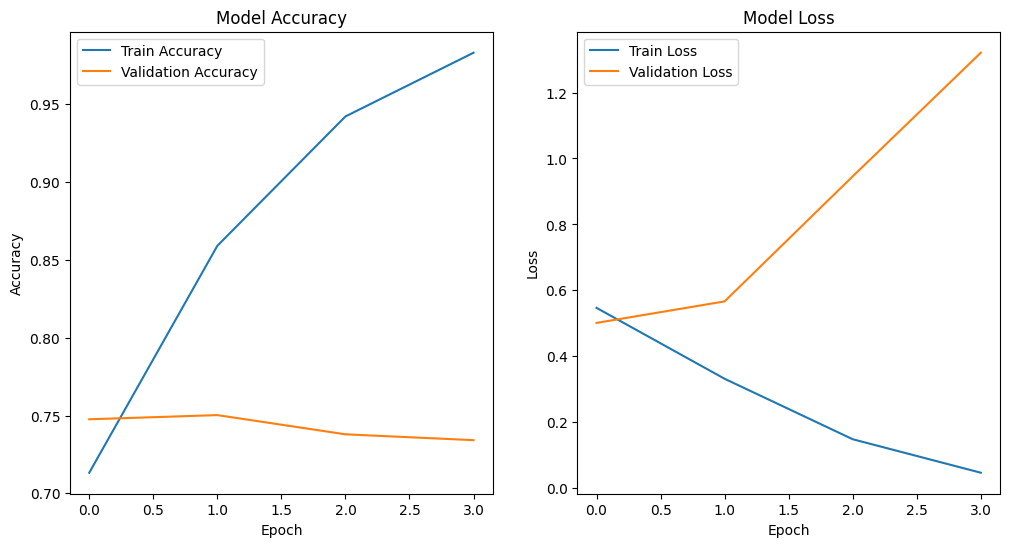

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt

# Load dataset
train_df = pd.read_csv('Train_data.csv')
test_df = pd.read_csv('Test_data.csv')

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2500)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_text']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text']).toarray()

# Labels
y_train = train_df['IsHatespeech'].values.astype(np.float32)
y_test = test_df['IsHatespeech'].values.astype(np.float32)

# Model
model = Sequential()
model.add(Dense(1024, input_dim=X_train_tfidf.shape[1], activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=[ tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0005)


# Training
history = model.fit(X_train_tfidf, y_train, epochs=40, batch_size=64, validation_data=(X_test_tfidf, y_test), verbose=2, callbacks=[early_stopping, reduce_lr])

y_pred_prob = model.predict(X_test_tfidf)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

print("Deep Learning Model Performance with TF-IDF:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()